## Evaluate
* Load the previously trained models
* Load the test data
* Evaluate the accuracy and inference speed of each model

In [1]:
from tensorflow.keras.utils import to_categorical

import numpy as np
from os.path import join
import pickle
import random
import pandas as pd
from matplotlib import pyplot as plt
import time

%matplotlib inline

2025-01-17 15:45:07.578865: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 15:45:07.586961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737125107.596769   11681 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737125107.599400   11681 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 15:45:07.609197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Global variables

In [2]:
DATA_PATH = 'data'
MODELS_PATH = 'models'

In [3]:
# input image dimensions
input_width = 300
input_height = 300
input_depth = 3
input_dim = input_width*input_height*input_depth
input_shape = (input_width, input_height, input_depth)

# classification classes
output_classes = 7

# size of sample used to train the model
NUM_TEST_SAMPLES = 1000

# Rescale the data (color) values
scale = False  # rather not

# number of times the accuracy tests should be repeated
NUM_TESTS = 10

## Test data
Load the data prepared in previous notebook

In [4]:
with np.load(join(DATA_PATH, 'test_data.npz')) as data:
    data_dict=dict(data.items())
X_test = data_dict['X']
y_test = data_dict['y']

Optionally subsample the data for faster training during try-outs

In [5]:
# Get a smaller random sample 
def sample_test_data():
    idx = random.sample(range(len(X_test)-1), NUM_TEST_SAMPLES)
    X_test_sub = X_test[idx]
    y_test_sub = y_test[idx]    
    return X_test_sub, y_test_sub

## Test accuracy
Test accuracy on test dataset for different models trained in previous notebooks

In [6]:
# define results matrix
eval_pd = pd.DataFrame(columns=['model', 'accuracy', 'CPU_time'])

### Dummy model
Dummy -most common category- model, used as baseline

In [7]:
with open(join(MODELS_PATH, 'dummy.pickle'), 'rb') as handle:
    dummy = pickle.load(handle)

In [8]:
%%time

model_name = 'dummy'
for _ in range(NUM_TESTS):
    X_test_sub, y_test_sub = sample_test_data()
    # Flatten images, as required by dumnmy and SVn models
    X_flat = [img.flatten() for img in X_test_sub]

    start = time.process_time()
    # Compute accuracy on the test set
    accuracy = dummy.score(X_flat, y_test_sub)
    dtime = time.process_time() - start
    
    eval_pd.loc[len(eval_pd)] = {'model': model_name , 'accuracy': accuracy, 'CPU_time': dtime}

CPU times: user 471 ms, sys: 363 ms, total: 834 ms
Wall time: 833 ms


### SVN
Support Vector Machine, also applied to flattened images

In [9]:
with open(join(MODELS_PATH, 'pipe_svc.pickle'), 'rb') as handle:
    svn = pickle.load(handle)

In [10]:
%%time

model_name = 'svn'
for _ in range(NUM_TESTS):
    X_test_sub, y_test_sub = sample_test_data()
    # Flatten images, as required by dumnmy and SVn models
    X_flat = [img.flatten() for img in X_test_sub]

    start = time.process_time()
    # Compute accuracy on the test set
    accuracy = svn.score(X_flat, y_test_sub)
    dtime = time.process_time() - start
    
    eval_pd.loc[len(eval_pd)] = {'model': model_name , 'accuracy': accuracy, 'CPU_time': dtime}

CPU times: user 12h 7min 41s, sys: 5.68 s, total: 12h 7min 46s
Wall time: 1h 57s


### CNN
Convolutional Neural Network model, applied to 2D image data

In [11]:
with open(join(MODELS_PATH, 'cnn.pickle'), 'rb') as handle:
    cnn = pickle.load(handle)

2025-01-17 16:46:14.122339: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [17]:
%%time

model_name = 'cnn'
for _ in range(NUM_TESTS):
    X_test_sub, y_test_sub = sample_test_data()
    # One-hot encode the labels
    _, y_test_preprocessed = np.unique(y_test_sub, return_inverse=True)

    start = time.process_time()
    # Compute accuracy on the test set
    (_, accuracy) = cnn.evaluate(X_test_sub, y_test_preprocessed, batch_size=32)
    dtime = time.process_time() - start
    
    eval_pd.loc[len(eval_pd)] = {'model': model_name , 'accuracy': accuracy, 'CPU_time': dtime}

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 341ms/step - acc: 0.1456 - loss: 1.9468
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 572ms/step - acc: 0.1487 - loss: 1.9462
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 563ms/step - acc: 0.1246 - loss: 1.9520
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 563ms/step - acc: 0.1594 - loss: 1.9403
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 563ms/step - acc: 0.1748 - loss: 1.9399
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 561ms/step - acc: 0.1708 - loss: 1.9423
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 560ms/step - acc: 0.1522 - loss: 1.9415    
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 560ms/step - acc: 0.1593 - loss: 1.9486
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 559ms/step - acc: 0.1642 - loss: 1.9420
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 560ms/step - acc: 0.1630 - loss: 1.9444
CPU times: user 25min 36s, sys: 1.45 s, total: 25min 37s
Wall time: 2min 53s


### Transfer learning
Using MobileNetV3Small

In [13]:
with open(join(MODELS_PATH, 'transfer_mobilenet.pickle'), 'rb') as handle:
    transfer_mobilenet = pickle.load(handle)

In [18]:
%%time

model_name = 'transfer'
for _ in range(NUM_TESTS):
    X_test_sub, y_test_sub = sample_test_data()
    # One-hot encode the labels
    _, y_test_classes = np.unique(y_test_sub, return_inverse=True)
    y_test_preprocessed = to_categorical(y_test_classes, num_classes=output_classes)
    
    start = time.process_time()
    # Compute accuracy on the test set
    (_, accuracy) = transfer_mobilenet.evaluate(X_test_sub, y_test_preprocessed, batch_size=32)
    dtime = time.process_time() - start
    
    eval_pd.loc[len(eval_pd)] = {'model': model_name , 'accuracy': accuracy, 'CPU_time': dtime}


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.6289 - loss: 1.5463
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.6432 - loss: 1.6263
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.6255 - loss: 1.7138
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.6573 - loss: 1.6644
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.6380 - loss: 1.5681
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.6585 - loss: 1.5646
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.5991 - loss: 1.8261
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.6207 - loss: 1.7404
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.6391 - loss: 1.5817
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.6020 - loss: 1.8262
CPU times: user 6min 45s, sys: 9.78 s, total: 6min 55s
Wall time: 54.7 s


In [19]:
# save evaluation results
eval_pd.to_csv('evaluation.csv', index=False) 

### Visualize results

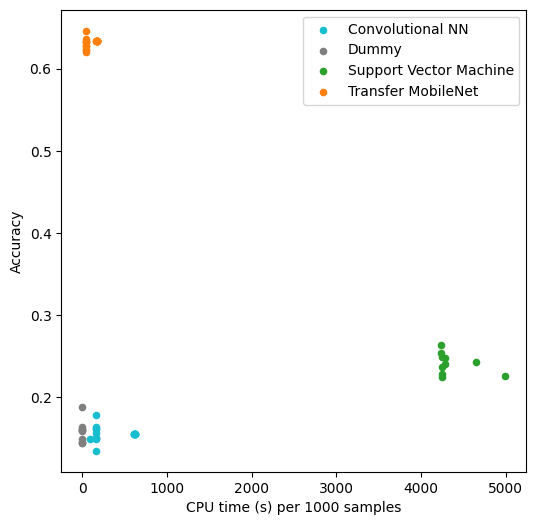

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))
colors = {'dummy':'tab:grey', 'svn':'tab:green', 'cnn':'tab:cyan', 'transfer':'tab:orange'}
labels = {'dummy':'Dummy', 'svn':'Support Vector Machine', 'cnn':'Convolutional NN', 'transfer':'Transfer MobileNet'}
grouped = eval_pd.groupby('model')
for key,group in grouped:
    group.plot(ax=ax, kind='scatter', x='CPU_time', y='accuracy', label=labels[key], color=colors[key])
#ax.set_xscale('log')
ax.set_xlabel(f"CPU time (s) per {NUM_TEST_SAMPLES} samples")
ax.set_ylabel("Accuracy")
plt.legend()
plt.show()

### Averages per sample
Note that CPU time is cumulated over all CPUs used, so migt be larger than wall time.

In [44]:
avg_df = pd.DataFrame(columns=['model', 'average accuracy', 'average time'])
def get_eval_avg(model):
    acc_avg = eval_pd[eval_pd.model==model].accuracy.mean()
    time_avg = eval_pd[eval_pd.model==model].CPU_time.mean()/NUM_TEST_SAMPLES
    return acc_avg, time_avg
acc_avg, time_avg = get_eval_avg('dummy')
avg_df.loc[len(avg_df)] = {'model': 'Dummy' , 'average accuracy': acc_avg, 'average time': time_avg}
acc_avg, time_avg = get_eval_avg('svn')
avg_df.loc[len(avg_df)] = {'model': 'Support Vector Machine' , 'average accuracy': acc_avg, 'average time': time_avg}
acc_avg, time_avg = get_eval_avg('cnn')
avg_df.loc[len(avg_df)] = {'model': 'Convolutional NN' , 'average accuracy': acc_avg, 'average time': time_avg}
acc_avg, time_avg = get_eval_avg('transfer')
avg_df.loc[len(avg_df)] = {'model': 'Transfer MobileNet' , 'average accuracy': acc_avg, 'average time': time_avg}

In [45]:
avg_df

,model,average accuracy,average time
0,Dummy,0.157700,0.000002
1,Support Vector Machine,0.241400,4.365616
2,Convolutional NN,0.155364,0.384463
3,Transfer MobileNet,0.631554,0.104342
